In [ ]:
# Validation of Segmentation Algorithms
Load Input Images

In [1]:
import SimpleITK as sitk

mri_path = "../Data/BraTS2021_00000_flair.nii.gz"
mri_seg_ture_path = "../Data/BraTS2021_00000_seg.nii.gz" # ground truth
mri_seg_pred_path = "../Data/BraTS2021_00000_seg.nii.gz" # prediction
# label: [0. 1. 2. 4.]=[background, necrotic tumor core (NCR), Gd-enhancing tumor (ET), peritumoral edematous/invaded tissue (ED)]

ct_path = "../Data/volume-0.nii"
ct_seg_ture_path = "../Data/segmentation-0.nii" # ground truth
ct_seg_pred_path = "../Data/prediction-0.nii" # prediction
# label: [0. 1. 2]=[background, liver, tumor]

# Validation of Segmentation Algorithms
Metrics: Dice Score, Jaccard, volumetric overlap error (VOE), relative volume difference (RVD), average symmetric surface distance (ASSD), root means square symmetric surface distance (RMSD), maximum surface distance (MSD)[1].

Ref: [1]Bilic, P., et al.: The liver tumor segmentation benchmark (LiTS). arXiv preprint arXiv:1901.04056 (2019)


In [2]:
from surface import Surface
from medpy import metric
import SimpleITK as sitk
import numpy as np
import time
import os
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# for display
sub_size = 16
sup_size=20

In [3]:
def display(img, true, pred, slice, is_ct, title):
    img_slice = img[slice]
    ture_slice = true[slice]
    pred_slice = pred[slice]

    ture_slice[ture_slice==1]=1
    pred_slice[pred_slice==1]=2
    sum_slice=ture_slice+pred_slice

    if is_ct:
        # window transform
        windowWidth = 200; windowCenter=40
        minWindow = float(windowCenter) - 0.5 * float(windowWidth)
        maxWindow = float(windowCenter) + 0.5 * float(windowWidth)
        img_slice[img_slice < minWindow] = minWindow
        img_slice[img_slice > maxWindow] = maxWindow

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(21,5))
    cmp = mpl.colors.ListedColormap(['r','g','b', 'y'])
    ax1.imshow(img_slice, cmap='gray'); ax1.set_title("Input", fontsize=sub_size); ax1.axis('off')
    ax2.imshow(ture_slice, cmap='gray'); ax2.set_title("Ground Truth", fontsize=sub_size); ax2.axis('off')
    ax3.imshow(pred_slice, cmap='gray'); ax3.set_title("Prediction", fontsize=sub_size); ax3.axis('off')
    img4 = ax4.imshow(sum_slice, cmap=cmp); ax4.set_title("0:TN, 1:FN, 2:FP, 3:TP", fontsize=sub_size); ax4.axis('off')
    
    fig.subplots_adjust(right=0.9) # set width of the left three subplot equal to 0.9 
    # set the size of colorbar
    l=0.92; b=0.12; w=0.015; h=1-2*b #left, bottom, width, hight
    # set the position of colorbar
    rect = [l,b,w,h]
    cbar_ax = fig.add_axes(rect)
    cb1 = fig.colorbar(img4, cax=cbar_ax)
    # set the scale of colobar
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb1.locator = tick_locator
    cb1.set_ticks([0,1,2,3])
    cb1.update_ticks()

    fig.suptitle(title+', slice='+str(slice), fontsize=sup_size)
    plt.show()

In [4]:
def get_scores(true, pred, vxlspacing):
    scores = {'dice': [],
              'jaccard': [],
              'voe': [],
              'rvd': [],
              'assd': [],
              'rmsd': [],
              'msd': []}
    if not np.any(pred) and not np.any(true):
        # There are no objects in the prediction, in the reference, or both
        scores['dice'].append(1)
        scores['jaccard'].append(1)
        scores['voe'].append(0.)
        scores['rvd'].append(0)
        scores['msd'].append(0)
        scores['assd'].append(0)
        scores['rmsd'].append(0)
    else:
        scores['dice'].append(metric.dc(pred, true))
        jaccard = metric.binary.jc(pred, true)
        scores['jaccard'].append(jaccard)
        scores['voe'].append(1. - jaccard)
        scores['rvd'].append(metric.ravd(pred, true))
        scores['msd'].append(metric.hd(pred, true, voxelspacing=vxlspacing))

        evalsurf = Surface(pred, true, physical_voxel_spacing=vxlspacing, mask_offset=[0., 0., 0.], reference_offset=[0., 0., 0.])
        scores['assd'].append(evalsurf.get_average_symmetric_surface_distance())
        scores['rmsd'].append(evalsurf.get_root_mean_square_symmetric_surface_distance())
    return scores

def evaluator(true, pred, spacing):
    # Compute lesions segmentation scores.
    scores = get_scores(true, pred, spacing)

    gc.collect()

    # Print results to stdout.
    print("Computed Segmentation Metrics")
    for metric, value in scores.items():
        print("{}: {:.3f}".format(metric, float(value[0])))

## Segmentation metrics from massive organs (e.g. liver)

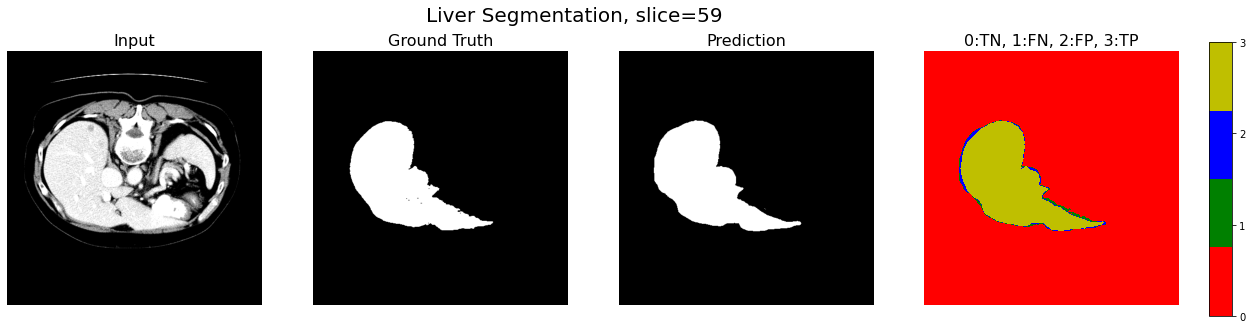

Computed Segmentation Metrics
dice: 0.990
jaccard: 0.981
voe: 0.019
rvd: -0.014
assd: 0.535
rmsd: 1.598
msd: 13.127


In [5]:
img_array = sitk.GetArrayFromImage(sitk.ReadImage(ct_path, sitk.sitkFloat32))
seg_ture_array = sitk.GetArrayFromImage(sitk.ReadImage(ct_seg_ture_path, sitk.sitkFloat32))
seg_pred = sitk.ReadImage(ct_seg_pred_path, sitk.sitkFloat32)
spacing = seg_pred.GetSpacing()
seg_pred_array = sitk.GetArrayFromImage(seg_pred)

# print('true.shape', seg_ture_array.shape, 'labels', np.unique(seg_ture_array))
# print('pred.shape', seg_pred_array.shape, 'labels', np.unique(seg_pred_array))

# select the liver region
seg_ture_array = (seg_ture_array >0).astype(np.int8)
seg_pred_array = (seg_pred_array >0).astype(np.int8)

display(img_array, seg_ture_array, seg_pred_array, slice=59, is_ct=True, title='Liver Segmentation')
    
evaluator(seg_ture_array, seg_pred_array, spacing)

## Segmentation metrics from lesion masks (e.g. liver tumor).

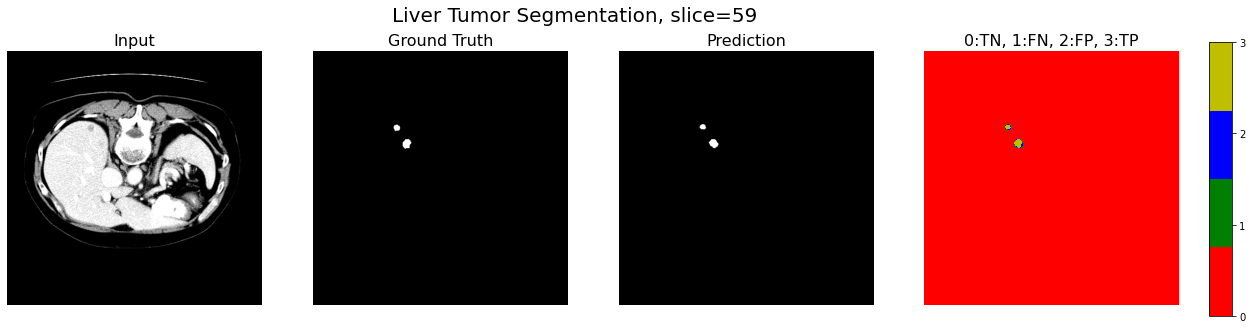

Computed Segmentation Metrics
dice: 0.977
jaccard: 0.954
voe: 0.046
rvd: -0.014
assd: 0.043
rmsd: 0.356
msd: 10.220


In [6]:
img_array = sitk.GetArrayFromImage(sitk.ReadImage(ct_path, sitk.sitkFloat32))
seg_ture_array = sitk.GetArrayFromImage(sitk.ReadImage(ct_seg_ture_path, sitk.sitkFloat32))
seg_pred = sitk.ReadImage(ct_seg_pred_path, sitk.sitkFloat32)
spacing = seg_pred.GetSpacing()
seg_pred_array = sitk.GetArrayFromImage(seg_pred)

# print('true.shape', seg_ture_array.shape, 'labels', np.unique(seg_ture_array))
# print('pred.shape', seg_pred_array.shape, 'labels', np.unique(seg_pred_array))

# select the tumor region
seg_ture_array = (seg_ture_array >1).astype(np.int8)
seg_pred_array = (seg_pred_array >1).astype(np.int8)

display(img_array, seg_ture_array, seg_pred_array, slice=59, is_ct=True, title='Liver Tumor Segmentation')
    
evaluator(seg_ture_array, seg_pred_array, spacing)